In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from scipy import stats
import sklearn as sk
import itertools
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from cleanup import postsFromCSV

from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from term_freq import COUNT

In [14]:

words = postsFromCSV("tf.csv")


#words = words.head(200)
unique = words[words['count_word'] >= 3600]['word'].unique()

#print(words)
#print(len(words))
#print(len(unique))
#print(unique)

top = [ [] for _ in range(len(unique))]
df = pd.DataFrame({"period": range(COUNT)})

#print(df)

for i,word in enumerate(unique):
    for period in range(COUNT):
        try:
            val = float(words.loc[(words['period'] == period) & (words['word'] == word)]['tf'])
        except:
            val = 0
        top[i].append(val) #words[words['period'] == period]['word' == word]

print(top)

for i,word in enumerate(unique):
    df[word] = pd.DataFrame(top[i])
print(df)

[[0, 0, 0, 0, 13.297489574689994, 27.02029726354952, 6.838733395202038, 4.49577835447202, 2.9881755456947188, 2.725435355123206], [3.093680229323229, 3.0081386589982846, 4.881031816683414, 5.461400059810665, 8.530364437210938, 7.604607987813586, 5.969881597647197, 4.054807700243712, 3.723463376681116, 5.450870710246412], [6.167991942697365, 6.51681588768307, 7.322343978176294, 7.753325129794045, 7.1942190390058505, 7.137730646561036, 6.638780917539777, 6.173589159196301, 6.061849676387856, 7.0840903987097565], [9.163068818097942, 8.457629655438081, 9.416489765758248, 10.224191943209284, 8.532141226304297, 6.954641493128664, 6.842319986729612, 7.450517550985758, 5.300912269901933, 1.1228385358185493], [5.609826528528063, 6.4211246905371215, 4.795036476356855, 4.803237619927737, 6.165458153951668, 5.965960064593853, 5.916979372615477, 5.71375345024165, 7.942818546353057, 6.00208235510279], [5.081594275370995, 5.168551456101049, 6.452835537096638, 5.918559445427671, 7.759237970693641, 5.7

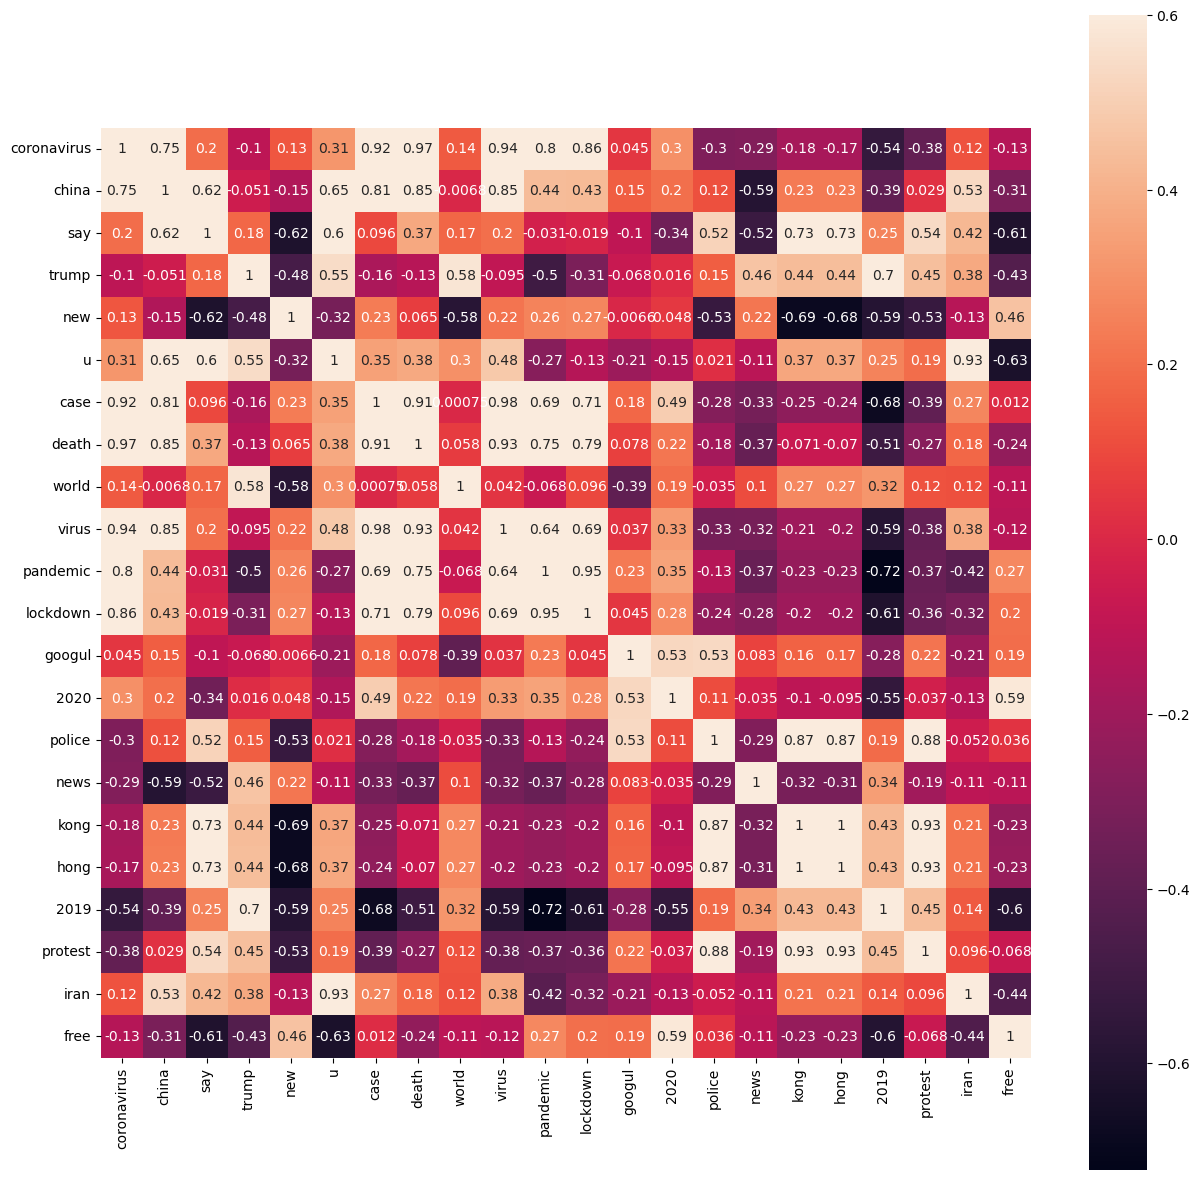

In [18]:
fig, ax = plt.subplots(figsize=(15,15))
correlation = df.drop('period', axis=1).corr()
foo = sns.heatmap(correlation, vmax=0.6, square=True, annot=True, ax=ax)

In [30]:
s = correlation.unstack()
so = s.sort_values(kind="quicksort", ascending=False)
print(so[len(unique):len(unique)+40:2])

kong         hong           0.999944
virus        case           0.978605
coronavirus  death          0.972266
lockdown     pandemic       0.953508
virus        coronavirus    0.941933
             death          0.934406
hong         protest        0.926071
protest      kong           0.925893
u            iran           0.925603
case         coronavirus    0.924557
death        case           0.908952
police       protest        0.880733
             hong           0.872954
             kong           0.871384
coronavirus  lockdown       0.861640
death        china          0.847456
virus        china          0.845418
china        case           0.813098
pandemic     coronavirus    0.799015
lockdown     death          0.787919
dtype: float64


In [31]:

so = s.sort_values(kind="quicksort", ascending=True)
print(so[0:40:2])

pandemic     2019    -0.721972
new          kong    -0.685056
             hong    -0.684483
case         2019    -0.679949
free         u       -0.626075
say          new     -0.616766
lockdown     2019    -0.612118
say          free    -0.609697
2019         free    -0.595041
new          2019    -0.591256
news         china   -0.588300
virus        2019    -0.586456
new          world   -0.580486
2019         2020    -0.545041
coronavirus  2019    -0.538709
protest      new     -0.529348
police       new     -0.526869
say          news    -0.517573
2019         death   -0.509578
pandemic     trump   -0.500205
dtype: float64
